In [3]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [4]:
sys.path.append('../../utils/')
from layers import wide_resnet, wide_resnet_snorm
import tfops

In [5]:
#
import tensorflow as tf

# tf.enable_eager_execution()

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
import tensorflow_probability as tfp
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors


In [6]:
nc = 32
nsize = 1000
lins = np.random.normal(size=nsize*nc**3).reshape(nsize, nc, nc, nc)

In [17]:
sys.path.append('../../utils/flowpm/')
import tfpmconfig, tfpm
import tfpmfuncs as tfpf
import tfpmfuncs
sys.path.append('../../utils/')
import tools


In [18]:
bs, nc = 100, 32
config = tfpmconfig.Config(bs=bs, nc=nc)
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

# path = '../../data/toy/L0100_N0032/S{:04d}/'
path = '../../../galmodel/data/toy/L0100_N0032/S{:04d}/'
seed = 0 
s = np.load(path.format(seed) + 's.npy')
d = np.load(path.format(seed) + 'd.npy')
p = np.load(path.format(seed) + 'p.npy')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
lins, fins, finsample = [], [], []
for seed in range(1000):
    lins.append(np.load(path.format(seed)+'s.npy'))
    fins.append(np.load(path.format(seed)+'d.npy'))
    finsample.append(np.load(path.format(seed)+'p.npy'))

lins = np.array(lins)
fins = np.array(fins)
finsample = np.array(finsample)

# Check

In [20]:
tf.reset_default_graph()

xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='output')
# net = wide_resnet(xx, 1)
net = slim.conv3d(xx, 1, 3)
print(net, xx, yy)
loss = tf.reduce_mean(tf.square(net-yy))

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

for i in range(2000):
    inds = np.random.randint(0, data_size, batch_size)
    x = np.expand_dims(lins[inds], -1)
    y = np.expand_dims(fins[inds], -1)
#     y = x.copy()
    y *= y
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.01})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

pred = sess.run(net, feed_dict={xx:x, yy:y, lr:0.001})
        

Tensor("Conv/Relu:0", shape=(?, 32, 32, 32, 1), dtype=float32) Tensor("input:0", shape=(?, 32, 32, 32, 1), dtype=float32) Tensor("output:0", shape=(?, 32, 32, 32, 1), dtype=float32)
7333.7686
7023.3623
7941.342
6387.399
6523.635
11840.612
4861.6445


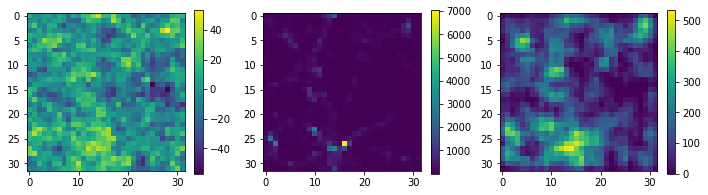

In [21]:
xt = x[0:1, ...].copy()
yt = y[0:1, ...].copy()
pt = pred[0:1, ...].copy()



fig, ax = plt.subplots(1, 3, figsize = (12, 3))
im = ax[0].imshow(np.squeeze(xt).sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(yt).sum(axis=0))
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pt).sum(axis=0))
plt.colorbar(im, ax=ax[2])


In [22]:
x0 = pt.copy()
xf = pt.copy()

for i in range(2000):
    xi = sess.run(net, feed_dict={xx:xf, yy:pt})
    xf = pt - xi

Text(0.5, 1.0, 'Estimated Inverse')

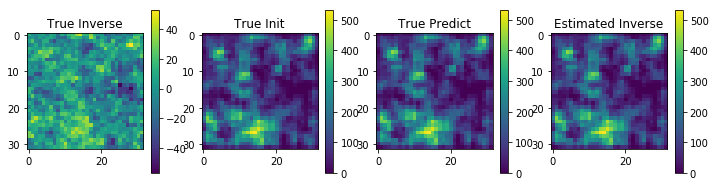

In [23]:
fig, ax = plt.subplots(1, 4, figsize = (12, 3))
im = ax[0].imshow(xt[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True Inverse')

im = ax[1].imshow(x0[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('True Init')

im = ax[2].imshow(pt[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('True Predict')

im = ax[3].imshow(xf[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[3])
ax[3].set_title('Estimated Inverse')


In [26]:
xf

array([[[[[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         ...,

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]]],


        [[[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan

In [24]:
x0 = pt.copy()
xf = pt.copy()

for i in range(2000):
    xi = sess.run(net, feed_dict={xx:xf, yy:pt})
#     xf2 = pt2 - xi
    xf = xi/np.linalg.norm(xi)
    
    
print(np.linalg.norm(xf))

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

nan


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/colors.py:902: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/chmodi/.local/lib/python3.6/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
/home/chm

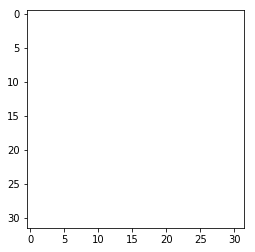

In [25]:
plt.imshow(xf[0,...,0].sum(axis=0))

### Specnorm

In [ ]:
tf.reset_default_graph()


xx2 = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='input')
yy2 = tf.placeholder(tf.float32, shape=[None, nc, nc, nc, 1], name='output')
net2 = wide_resnet_snorm(xx2, 1)
# net2 = tfops.specnormconv3d(xx2, 1, name='specnorm')
loss2 = tf.reduce_mean(tf.square(net2-yy2))
    
optimizer2 = tf.train.AdamOptimizer(learning_rate=0.01)
train_op2 = optimizer2.minimize(loss2)

sess2 = tf.Session()
sess2.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = np.expand_dims(lins[inds], -1)
    y = np.expand_dims(fins[inds], -1)
#     y = x.copy()
    y *= y
    l,_= sess2.run([loss2, train_op2], feed_dict={xx2:x, yy2:y})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

pred2 = sess2.run(net2, feed_dict={xx2:x, yy2:y})
        

../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:36: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'


6679.6113
7557.8286
5584.426
8248.034
5534.373


In [ ]:
xt2 = x[0:1, ...].copy()
yt2 = y[0:1, ...].copy()
pt2 = pred2[0:1, ...].copy()



fig, ax = plt.subplots(1, 3, figsize = (12, 3))
im = ax[0].imshow(np.squeeze(xt2).sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(yt2).sum(axis=0))
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pt2).sum(axis=0))
plt.colorbar(im, ax=ax[2])


In [ ]:
xf2.shape

In [ ]:
x02 = pt2.copy()
xf2 = pt2.copy()

for i in range(20):
    xi = sess2.run(net2, feed_dict={xx2:xf2, yy2:pt2})
    xf2 = pt2 - xi

In [ ]:
xf2

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (12, 3))
im = ax[0].imshow(xt2[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True Inverse')

im = ax[1].imshow(x02[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('True Init')

im = ax[2].imshow(pt2[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('True Predict')

im = ax[3].imshow(xf2[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[3])
ax[3].set_title('Estimated Inverse')


In [ ]:
fig, axar = plt.subplots(2, 3, figsize = (12, 8))

ax = axar[0]

im = ax[0].imshow(xt[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True Inverse')

im = ax[1].imshow(xf[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Estimated Inverse')


im = ax[2].imshow((xt-xf)[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Diff Inverse')

ax = axar[1]

im = ax[0].imshow(xt2[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('True Inverse')

im = ax[1].imshow(xf2[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Estimated Inverse')


im = ax[2].imshow((xt2-xf2)[0,...,0].sum(axis=0))
# im = ax[3].imshow((xt-xf)[0,...,0].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Diff Inverse')


In [ ]:
x02 = pt2.copy()
xf2 = pt2.copy()

for i in range(2000):
    xi = sess2.run(net2, feed_dict={xx2:xf2, yy2:pt2})
#     xf2 = pt2 - xi
    xf2 = xi/np.linalg.norm(xi)
    

In [ ]:
# def poweriter(mat):
#     u = np.random.normal(size=mat.shape[-1])
#     for i in range(100):
#         v = np.matmul(u, mat.T)
#         v = v/np.linalg.norm(v)
#         u = np.matmul(v, mat)
#         u = u/np.linalg.norm(u)

#     return np.matmul(np.matmul(v, mat), np.transpose(u))





In [137]:
np.linalg.norm(xf2)

1.000007

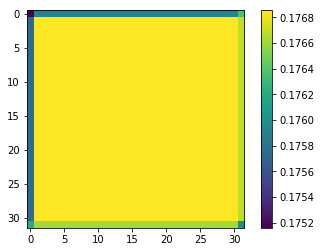

In [138]:
im = plt.imshow(xf2[0,...,0].sum(axis=0))
plt.colorbar(im)

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

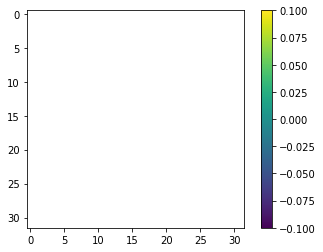

In [140]:
im = plt.imshow(xf[0,...,0].sum(axis=0))
plt.colorbar(im)

In [141]:
np.linalg.norm(xf)

nan